In [31]:
from scipy.stats import norm, poisson
import matplotlib.pyplot as plt
import numpy as np

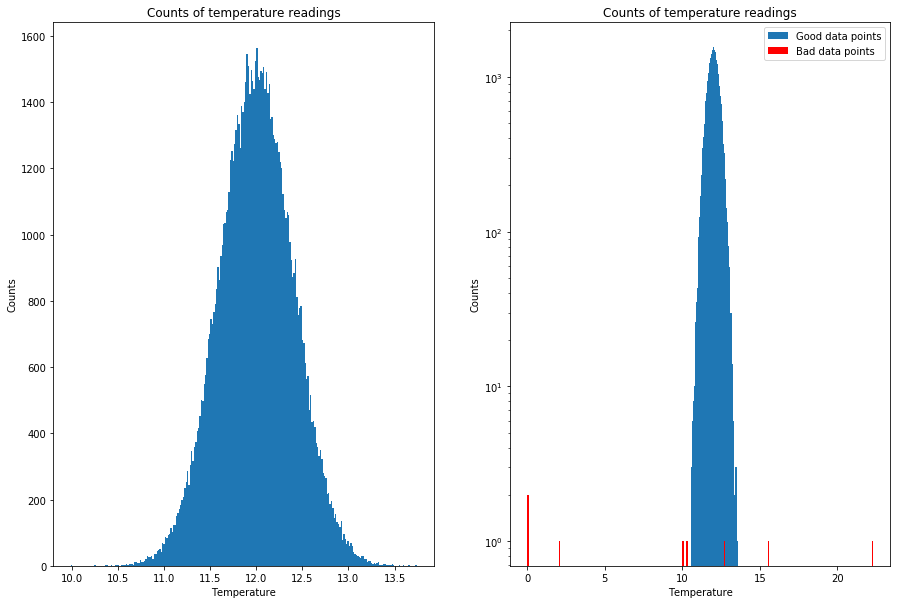

In [16]:
gbp = norm.rvs(loc = 12, scale = 0.4, size = 10**5)
bad = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
# bbp = np.concatenate((gbp, np.array(bad)))
fig, a = plt.subplots(1, 2, figsize=(15, 10))

a[0].hist(gbp, bins = 250)
# a[1].hist(bad, bins = 250, color='r') Scale too extreme for bad data points to be visible!
a[1].hist(gbp, bins = 250, label="Good data points")
a[1].hist(bad, bins = 250, color='r', label='Bad data points')
a[1].set_yscale('log')

a[0].set_xlabel('Temperature')
a[1].set_xlabel('Temperature')
a[0].set_ylabel('Counts')
a[1].set_ylabel('Counts')
a[0].set_title("Counts of temperature readings")
a[1].set_title("Counts of temperature readings")

a[1].legend(loc='upper right')

plt.show()

We seek to eliminate bad data points, but need a criterion to identify such data points. We first pick some given point $x$ and ask what the probability is, assuming the background is correct, of measuring a value as or more extreme than than $x$. As we are assuming a normal distribution, this probability can be found by integrating from $x$ to infinity. As in previous labs, using that the normal distribution itself is normalized, we can use SciPy's norm.cdf() with the appropriate parameters to integrate from negative infinity to $x$, and then just subtract this quantity from 1 to get the desired integral. This will give us a probability, and the sigma associated with this probability can be found from SciPy's norm.ppf() acting on 1 minus the probability, as we detailed in lab 1.

We know our data is normally distributed, so any event with a high sigma looks less data-like. We then want to eliminate all events of a suitably high sigma, such that we remove a maximal number of bad data points while keeping as much of the original data as possible. We keep much of the data (around 99.7%) with a cutoff of $3\sigma$ on our data points, so we ask: What fraction total of the bad data points period will be thrown out with this cutoff? We calculate the cutoff values at plus and minus $3\sigma$ from the mean of the distribution, noting our normal distribution has parameters of mean = 12 (in SciPy's terms, loc = 12.), and sigma = 0.4 (scale = 0.4). This allows us to make our cut - if a data point does not lie between the two cutoff values, it is excluded. We list our bad data points, noting which do not survive the cut, and then graph the entire distribution before and after the cut.

10.0  is eliminated by the cut!
10.3  is eliminated by the cut!
2.1  is eliminated by the cut!
0.0  is eliminated by the cut!
0.0  is eliminated by the cut!
15.6  is eliminated by the cut!
22.3  is eliminated by the cut!
12.7  survives the cut!


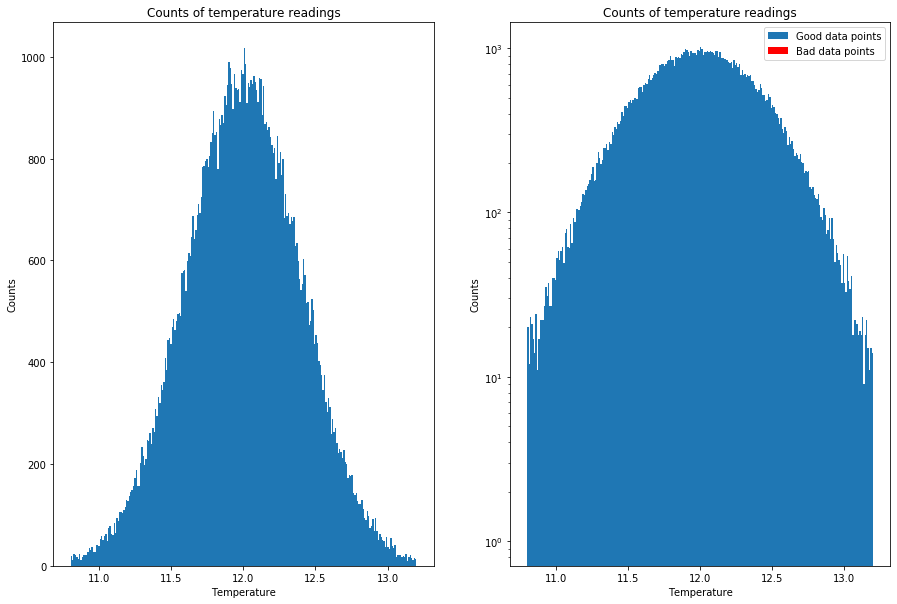

In [18]:
pSig = norm.ppf(norm.cdf(3), loc=12., scale=0.4)
mSig = norm.ppf(norm.cdf(-3), loc=12., scale=0.4)

surv = []
for b in bad:
    if b < pSig and b > mSig:
        surv.append(b)
        print(b, ' survives the cut!')
    else:
        print(b, ' is eliminated by the cut!')
        
idx = np.where((gbp > mSig) & (gbp < pSig))
               
fig, a = plt.subplots(1, 2, figsize=(15, 10))

a[0].hist(gbp[idx], bins = 250)
# a[1].hist(bad, bins = 250, color='r') Scale too extreme for bad data points to be visible!
a[1].hist(gbp[idx], bins = 250, label="Good data points")
a[1].hist(surv, bins = 250, color='r', label='Bad data points')
a[1].set_yscale('log')

a[0].set_xlabel('Temperature')
a[1].set_xlabel('Temperature')
a[0].set_ylabel('Counts')
a[1].set_ylabel('Counts')
a[0].set_title("Counts of temperature readings")
a[1].set_title("Counts of temperature readings")

a[1].legend(loc='upper right')

plt.show()

So our $3\sigma$ threshhold eliminates all but a single of our bad data points, and the bin of the single bad data point that survives is highly populated already, so as to have a minimal effect on our statistics. The left graph, which shows the raw histogram, shows how little we have lost of our origninal data - we only are losing points in the exponentially suppressed tails. We then seek to quatify how good our cut was: how many data points were correctly kept as good, or excluded as bad, and how many mistakes did we make?

In [26]:
tp = 0
for p in gbp:
    if p > mSig and p < pSig:
        tp += 1

print(tp, " good data points were correctly kept by our cut.")
print(10**5 - tp, " good data points were incorrectly excluded by our cut.")
print(len(bad) - len(surv), ' bad data points were correctly excluded by our cut.')
print(len(surv), ' bad data points were incorrectly included by our cut.')

99739  good data points were correctly kept by our cut.
261  good data points were incorrectly excluded by our cut.
7  bad data points were correctly excluded by our cut.
1  bad data points were incorrectly included by our cut.


We now see how good a job our cut actually did: only a small fraction of the good data points were thrown out, but the majority of bad data points were eliminated!

Our number of omissions depends predictably on our sigma cutoff, since the fraction of omissions out of the total number of events ought to go like the probability of choosing a point at random from the standard normal distribution and having it lie outside of the interval $(-3\sigma, +3\sigma)$. This is clearly just a difference of normal cdf functions multiplying our total sample size: the number of omissions is going to be normally distributed itself, and be centered about $S (CDF_N(n\sigma) - CDF_N(-n\sigma))$, where $S$ is the sample size, $CDF_N$ is the cumulative distribution function of the standard normal distribution, and $n$ is the positive-real number corresponding to the number of sigma in our cutoff value.

We do have mistakes of comission - the 12.7 bad data point survives our cut. It is theoretically avoidable in this particular circumstance, as we could have chosen a cutoff between 12.7 and 12 which would then exclude this value. However, this would throw out a very large portion of our data compared to our current cut, so as to mangle our underlying signal. There is no nice analytic expression for this bad data distribution, so we are reduced to just stating that in general, as the cutoff gets smaller in magnitude, we are necessarily including less data overall, so that also we include less bad data.

In effect, we may forget all the pretty setup on how we obtained this pretty 2D histogram. We are given a distribution, from on high, and wish to determine a $5\sigma$ result from it. We first then want to state formally what is asked when we ask the probability of a certain measurement. We first define what it means to be signal like, and here is the only place where the setup to our data will be important: we expect actually moving bodies to have greater observed movement between images than stationary bodies, so we interpret measuremnts corresponding to a larger total movement across both images (and by total movement, we refer to the quantity $((\Delta x)^2 + (\Delta y)^2)^{1/2}$) as corresponding to something that looks more signal like, which is to say, more like the moving meteorites we seek to observe. Asking for the probability of a given measurement then means: given a measurement, assuming the background has the form of a two-dimensional gaussian, what is the probability that the background produces a data point as or more signal-like than the given measurement, which is to say, a data point corresponding to greater total movement?

We are assuming the background to be a two dimensional Gaussian, and we cite from the Blue Book the normalized form of this distribution's pdf as $\frac{1}{2 \pi} e^{-\frac{x^2 + y^2}{2}}$, where we have now dropped the deltas for brevity. This is the density of probability, so to find the probability of generating a data point more signal like that a given measurement $m$ of total movement $r_0 = (x_0^2 + y_0^2)^{1/2}$ will then be given by:

$\int_{(x^2 + y^2)^{1/2} > r_0} \frac{1}{2 \pi} e^{-\frac{x^2 + y^2}{2}} dx dy = \int_0^{2\pi} \int_{r_0}^{\infty} \frac{1}{2 \pi} e^{-\frac{r^2}{2}} r dr d\theta = \int_0^{2\pi} [ - \frac{1}{2 \pi} e^{-\frac{r^2}{2}} ]_{r = r_0}^{r \to \infty} d\theta = \int_0^{2\pi} \frac{1}{2 \pi} e^{-\frac{r_0^2}{2}} d\theta = e^{-\frac{r_0^2}{2}}$.

A $5\sigma$ result corresponds to a measurement that has a probability of 1 - norm.cdf(5) = p. We assume the measurement probability we found immediately above is such a value; we then have equality, and thus, $e^{-\frac{r_0^2}{2}} = p$, so that $\frac{r_0^2}{2} = ln(\frac{1}{p}) \implies r_0 = (2ln(1/p))^{1/2}$. This allows us to calculate $r_0$:

In [30]:
xsig = norm.cdf(5)
mov = (2 * np.log(1 / (1 - xsig)))**(1/2)
print('We calculate the movement required for a five sigma result to be ', mov)

0.9999997133484281
We calculate the movement required for a five sigma result to be  5.489079776034238


First, we state our background. We are assuming there will be 1 event per minute, on average, and on each of our 15 days, there will be 8 hours of useable observation time, with 60 minutes in each hour. We then note that there are 8 * 60 * 15 = 7200 expected events, on average, over this 15 day observation period. This suggests a Poisson model for the background, of mean 7200, which we shall use. We then define the probability of a measurement to be the probability that, assuming the only source of data is our Poisson background, the background generates a data point as or more signal like than our measurement. We then define what it means to be signal like: we are checking to see if the shadow of a celestial body reduces our ray count, so a stronger signal corresponds to fewer events! Higher numbers of events than expected would say nothing about whether a celestial body absorbs rays - it could be due to a solar flare, or some distant ray burst. Thus, the probability of a measurement is the probability that the background produces a data point with fewer events than our measurement, which corresponds to integrating from zero to our measurement. The associated sigma of the measurement will then be the result of a call of norm.ppf on one minus this measurement probability.

In [32]:
p = poisson.cdf(6800, mu=7200)
sig = norm.ppf(1 - p)
print('For a measurement of 6800 gamma ray events we measure a sigma of ', sig)

For a measurement of 6800 gamma ray events we measure a sigma of  4.750747965778662
